In [1]:
import numpy as np
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, recall_score

#### **Creating a Neural Network with TfidfVectorizer and Pytorch**

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**A. Loading the Tokenized tweets**

In [127]:
tweets_train_tokenized = pd.read_csv('csvs/tweets_train_tokens.csv', index_col=False)
tweets_train_tokenized_message = pd.Series(tweets_train_tokenized.message)
# Converting Panda series into Unicode datatype as required by vectorizers
tweets = tweets_train_tokenized_message.astype('U').values
tweets

array(['arirang simply kpop kim hyung jun cross ha yeong playback',
       'read politico article donald trump running mate tom brady list likely choice',
       'type bazura project google image image photo dad glenn moustache whatthe',
       ..., 'bring dunkin iced coffee tomorrow hero',
       'currently holiday portugal come home tomorrow poland tuesday holocaust memorial trip',
       'ladykiller saturday aternoon'], dtype=object)

**B. Loading our target labels**

In [128]:
tweets_train_y = pd.read_csv('csvs/tweets_train_y.csv', index_col=False)
tweets_train_y = pd.Series(tweets_train_y['0'])
tweets_train_y = tweets_train_y.values
tweets_train_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [129]:
np.unique(tweets_train_y)

array([0, 1, 2], dtype=int64)

**C. Train-test Split**

In [130]:
X_full_train, X_test, y_full_train, y_test = train_test_split(tweets, tweets_train_y, test_size=0.2, random_state=21)
print('# Train data samples:', X_full_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_full_train.shape[0] == y_full_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 39740
# Test data samples: 9935


**D. Converting target labels into onehot-encoded vectors**

In [131]:
le = LabelEncoder()
y_full_train_le = le.fit_transform(y_full_train)
y_test_le = le.transform(y_test)
y_full_train_oh = to_categorical(y_full_train_le)
y_test_oh = to_categorical(y_test_le)
y_full_train_oh.shape

(39740, 3)

**E. Converting input texts to vectors using TfidfVectorizer**

In [132]:
# you can also specify ngram_range
# you can also choose the max_features parameter, which just includes those features with the top frequencies specified by the max_features i.e.
# max_features = 7500, includes only those top 7500 features with the highest frequencies
# min_df includes only words which appear at least twice in every document
# ngram_range=(1,2)
tfidf = TfidfVectorizer(min_df=2, max_features=5000, ngram_range=(1,2))
X_full_train_vec = tfidf.fit_transform(X_full_train).toarray()
X_full_train_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [133]:
X_test_vec = tfidf.transform(X_test).toarray()
X_test_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**F. Splitting train set for validation**

In [134]:
X_train_vec, X_val_vec, y_train_vec, y_val_vec = train_test_split(X_full_train_vec, y_full_train_oh, test_size=0.2, random_state=21)

assert X_val_vec.shape[0] == y_val_vec.shape[0]
assert X_train_vec.shape[0] == y_train_vec.shape[0]

print('Shape of validation set:',X_val_vec.shape)

Shape of validation set: (7948, 7500)


**G. Converting features and targets into Tensors**

In [135]:
X_train_vec = torch.from_numpy(X_train_vec).type(torch.float)
y_train_vec = torch.from_numpy(y_train_vec).type(torch.float)

X_val_vec = torch.from_numpy(X_val_vec).type(torch.float)
y_val_vec = torch.from_numpy(y_val_vec).type(torch.float)

In [136]:
print(f'X_train_vec shape: {X_train_vec.shape}, y_train_vec shape: {y_train_vec.shape}')

X_train_vec shape: torch.Size([31792, 7500]), y_train_vec shape: torch.Size([31792, 3])


**H. Creating our Neural Network Architecture** 

In [137]:
NUM_CLASSES = 3
NUM_FEATURES = 5000

class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 55) # input to first hidden layer, produces 55 features
        #self.hidden_layer_2 = nn.Linear(1000,100)
        #self.hidden_layer_3 = nn.Linear(100, 1000)
        #self.hidden_layer_4 = nn.Linear(1000, 10)
        self.output_layer = nn.Linear(55, self.out_dim) # takes in 5 features, produces 3 feature (y)
        
        self.activation = nn.ReLU()  # <- add in ReLU activation function
        #self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout(self.activation(self.hidden_layer_1(x)))
        
        #x = self.dropout(self.activation(self.hidden_layer_2(x)))
        #x = self.dropout(self.activation(self.hidden_layer_3(x)))
        #x = self.dropout(self.activation(self.hidden_layer_4(x)))
        
        y = self.output_layer(x)
        
        return y

In [138]:
# Create an instance of the model and send it to target device
model_0 = NeuralNetwork(in_dim=NUM_FEATURES, out_dim=NUM_CLASSES).to(device)
model_0

NeuralNetwork(
  (hidden_layer_1): Linear(in_features=7500, out_features=55, bias=True)
  (output_layer): Linear(in_features=55, out_features=3, bias=True)
  (activation): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [139]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=learning_rate)
batch_size = 200

In [140]:
# Test structure of model
# predictions_before are the logits, or the raw, untrained output of the model
predictions_before = model_0.forward(torch.Tensor(X_val_vec).float())
predictions_before

tensor([[0.3454, 0.3083, 0.3463],
        [0.3466, 0.3085, 0.3449],
        [0.3467, 0.3071, 0.3463],
        ...,
        [0.3456, 0.3084, 0.3460],
        [0.3462, 0.3070, 0.3468],
        [0.3452, 0.3088, 0.3460]], grad_fn=<SoftmaxBackward0>)

In [141]:
predictions_before.shape

torch.Size([7948, 3])

In [17]:
# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
#y_pred_probs = torch.softmax(predictions_before, dim=1) 
#print(predictions_before[:5])
#print(y_pred_probs[:5])

tensor([[ 0.2373, -0.0446, -0.2831],
        [ 0.2352, -0.0434, -0.2851],
        [ 0.2352, -0.0443, -0.2848],
        [ 0.2314, -0.0443, -0.2876],
        [ 0.2350, -0.0439, -0.2852]], grad_fn=<SliceBackward0>)
tensor([[0.4258, 0.3212, 0.2530],
        [0.4253, 0.3219, 0.2528],
        [0.4254, 0.3217, 0.2529],
        [0.4248, 0.3224, 0.2528],
        [0.4254, 0.3218, 0.2528]], grad_fn=<SliceBackward0>)


After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

These prediction probablities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value `using torch.argmax()`.

In [18]:
# Which class does the model think is *most* likely at the index 0 sample?
#print(y_pred_probs[0])
#print(torch.argmax(y_pred_probs[0]))

tensor([0.4258, 0.3212, 0.2530], grad_fn=<SelectBackward0>)
tensor(0)


You can see the output of torch.argmax() returns 0, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 0.

Of course, right now this is just random guessing so it's got a 33% chance of being right (since there's three classes). But we can improve those chances by training the model.

In [142]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [143]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (features, targets) in enumerate(loop):
        y_logits = model.forward(features)
        #y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

        # Calculate loss
        loss = loss_fn(y_logits, targets)
        #acc = accuracy_score(y_train_vec, y_pred)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss backwards
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset(x=X_train_vec, y=y_train_vec)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_0,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))

    
state = { 'state_dict': model_0.state_dict() }

torch.save(state, "./torch_models/model_0.pth")

Epoch: 0


100%|██████████| 318/318 [00:04<00:00, 79.45it/s, loss=0.962]


Ave Loss: 1.016651376988153
Epoch: 1


100%|██████████| 318/318 [00:03<00:00, 95.97it/s, loss=0.935] 


Ave Loss: 0.9166623455173565
Epoch: 2


100%|██████████| 318/318 [00:03<00:00, 93.54it/s, loss=0.89]  


Ave Loss: 0.8679184272604169
Epoch: 3


100%|██████████| 318/318 [00:03<00:00, 89.50it/s, loss=0.88]  


Ave Loss: 0.8319756204976976
Epoch: 4


100%|██████████| 318/318 [00:03<00:00, 89.38it/s, loss=0.867]


Ave Loss: 0.8096904194205062
Epoch: 5


100%|██████████| 318/318 [00:03<00:00, 93.33it/s, loss=0.855]


Ave Loss: 0.792295845986912
Epoch: 6


100%|██████████| 318/318 [00:03<00:00, 96.11it/s, loss=0.85]  


Ave Loss: 0.7787015829821052
Epoch: 7


100%|██████████| 318/318 [00:03<00:00, 95.22it/s, loss=0.83]  


Ave Loss: 0.7671589349050941
Epoch: 8


100%|██████████| 318/318 [00:03<00:00, 93.13it/s, loss=0.822] 


Ave Loss: 0.7559707459038908
Epoch: 9


100%|██████████| 318/318 [00:03<00:00, 92.64it/s, loss=0.812] 


Ave Loss: 0.7466137977141254
Epoch: 10


100%|██████████| 318/318 [00:03<00:00, 95.06it/s, loss=0.79] 


Ave Loss: 0.7385270929186599
Epoch: 11


100%|██████████| 318/318 [00:03<00:00, 95.28it/s, loss=0.773] 


Ave Loss: 0.7311348937592417
Epoch: 12


100%|██████████| 318/318 [00:03<00:00, 94.25it/s, loss=0.77] 


Ave Loss: 0.7241353956783343
Epoch: 13


100%|██████████| 318/318 [00:03<00:00, 93.29it/s, loss=0.744]


Ave Loss: 0.718253771089158
Epoch: 14


100%|██████████| 318/318 [00:03<00:00, 93.11it/s, loss=0.746]


Ave Loss: 0.7120319230001677
Epoch: 15


100%|██████████| 318/318 [00:03<00:00, 95.86it/s, loss=0.736] 


Ave Loss: 0.7073793366270246
Epoch: 16


100%|██████████| 318/318 [00:03<00:00, 95.59it/s, loss=0.744]


Ave Loss: 0.7027694620426346
Epoch: 17


100%|██████████| 318/318 [00:03<00:00, 94.78it/s, loss=0.728]


Ave Loss: 0.6980661950396292
Epoch: 18


100%|██████████| 318/318 [00:03<00:00, 93.46it/s, loss=0.72] 


Ave Loss: 0.6948265688224409
Epoch: 19


100%|██████████| 318/318 [00:03<00:00, 94.44it/s, loss=0.713]


Ave Loss: 0.6910875450890019
Epoch: 20


100%|██████████| 318/318 [00:03<00:00, 95.23it/s, loss=0.711]


Ave Loss: 0.6887604105022719
Epoch: 21


100%|██████████| 318/318 [00:03<00:00, 95.38it/s, loss=0.715]


Ave Loss: 0.6856539800481977
Epoch: 22


100%|██████████| 318/318 [00:03<00:00, 94.39it/s, loss=0.706]


Ave Loss: 0.6832308549925966
Epoch: 23


100%|██████████| 318/318 [00:03<00:00, 92.81it/s, loss=0.713]


Ave Loss: 0.6811255636455128
Epoch: 24


100%|██████████| 318/318 [00:03<00:00, 94.45it/s, loss=0.703]


Ave Loss: 0.6786789892229644
Epoch: 25


100%|██████████| 318/318 [00:03<00:00, 94.29it/s, loss=0.711]


Ave Loss: 0.6774776000646675
Epoch: 26


100%|██████████| 318/318 [00:03<00:00, 93.60it/s, loss=0.7]  


Ave Loss: 0.674957218972392
Epoch: 27


100%|██████████| 318/318 [00:03<00:00, 91.17it/s, loss=0.703]


Ave Loss: 0.6745038426147317
Epoch: 28


100%|██████████| 318/318 [00:03<00:00, 94.56it/s, loss=0.701]


Ave Loss: 0.6727455305228444
Epoch: 29


100%|██████████| 318/318 [00:03<00:00, 92.95it/s, loss=0.705]


Ave Loss: 0.6711211585023868
Epoch: 30


100%|██████████| 318/318 [00:03<00:00, 94.17it/s, loss=0.696]


Ave Loss: 0.6700561612657031
Epoch: 31


100%|██████████| 318/318 [00:03<00:00, 92.66it/s, loss=0.706]


Ave Loss: 0.6689768304240029
Epoch: 32


100%|██████████| 318/318 [00:03<00:00, 90.13it/s, loss=0.699]


Ave Loss: 0.66789969277082
Epoch: 33


100%|██████████| 318/318 [00:03<00:00, 93.64it/s, loss=0.704]


Ave Loss: 0.6668335600469097
Epoch: 34


100%|██████████| 318/318 [00:03<00:00, 93.95it/s, loss=0.696]


Ave Loss: 0.6662180907321427
Epoch: 35


100%|██████████| 318/318 [00:03<00:00, 95.28it/s, loss=0.696]


Ave Loss: 0.6653170199514186
Epoch: 36


100%|██████████| 318/318 [00:03<00:00, 91.86it/s, loss=0.695]


Ave Loss: 0.6646293907795312
Epoch: 37


100%|██████████| 318/318 [00:03<00:00, 93.31it/s, loss=0.695]


Ave Loss: 0.6640421564474046
Epoch: 38


100%|██████████| 318/318 [00:03<00:00, 94.19it/s, loss=0.696]


Ave Loss: 0.6634557652023604
Epoch: 39


100%|██████████| 318/318 [00:03<00:00, 93.11it/s, loss=0.695]


Ave Loss: 0.6625015986790447
Epoch: 40


100%|██████████| 318/318 [00:03<00:00, 91.88it/s, loss=0.699]


Ave Loss: 0.6617842972653467
Epoch: 41


100%|██████████| 318/318 [00:03<00:00, 93.53it/s, loss=0.693]


Ave Loss: 0.6615870669952728
Epoch: 42


100%|██████████| 318/318 [00:03<00:00, 92.94it/s, loss=0.697]


Ave Loss: 0.6607481083779965
Epoch: 43


100%|██████████| 318/318 [00:03<00:00, 93.97it/s, loss=0.703]


Ave Loss: 0.6600800986934758
Epoch: 44


100%|██████████| 318/318 [00:03<00:00, 90.89it/s, loss=0.693]


Ave Loss: 0.6599631725617174
Epoch: 45


100%|██████████| 318/318 [00:03<00:00, 93.08it/s, loss=0.696]


Ave Loss: 0.6591293594372347
Epoch: 46


100%|██████████| 318/318 [00:03<00:00, 92.43it/s, loss=0.694]


Ave Loss: 0.65844493654539
Epoch: 47


100%|██████████| 318/318 [00:03<00:00, 92.11it/s, loss=0.697]


Ave Loss: 0.6577402885604955
Epoch: 48


100%|██████████| 318/318 [00:03<00:00, 91.55it/s, loss=0.695]


Ave Loss: 0.6574129702160193
Epoch: 49


100%|██████████| 318/318 [00:03<00:00, 79.56it/s, loss=0.695]


Ave Loss: 0.6568740195823166
Epoch: 50


100%|██████████| 318/318 [00:03<00:00, 86.81it/s, loss=0.693]


Ave Loss: 0.6565007301246595
Epoch: 51


100%|██████████| 318/318 [00:03<00:00, 92.40it/s, loss=0.693]


Ave Loss: 0.6561272751610234
Epoch: 52


100%|██████████| 318/318 [00:03<00:00, 91.35it/s, loss=0.693]


Ave Loss: 0.6553615505965251
Epoch: 53


100%|██████████| 318/318 [00:03<00:00, 89.79it/s, loss=0.695]


Ave Loss: 0.6551454458971443
Epoch: 54


100%|██████████| 318/318 [00:03<00:00, 92.17it/s, loss=0.694]


Ave Loss: 0.6546823905324036
Epoch: 55


100%|██████████| 318/318 [00:03<00:00, 91.29it/s, loss=0.694]


Ave Loss: 0.6541871735884709
Epoch: 56


100%|██████████| 318/318 [00:03<00:00, 92.20it/s, loss=0.694]


Ave Loss: 0.6539538015359603
Epoch: 57


100%|██████████| 318/318 [00:03<00:00, 90.38it/s, loss=0.695]


Ave Loss: 0.6534659047171755
Epoch: 58


100%|██████████| 318/318 [00:03<00:00, 92.90it/s, loss=0.694]


Ave Loss: 0.6530810347143209
Epoch: 59


100%|██████████| 318/318 [00:03<00:00, 92.68it/s, loss=0.692]


Ave Loss: 0.6527039967243027
Epoch: 60


100%|██████████| 318/318 [00:03<00:00, 92.75it/s, loss=0.694]


Ave Loss: 0.6524481323530089
Epoch: 61


100%|██████████| 318/318 [00:03<00:00, 82.82it/s, loss=0.694]


Ave Loss: 0.6522250794014841
Epoch: 62


100%|██████████| 318/318 [00:03<00:00, 82.88it/s, loss=0.693]


Ave Loss: 0.6518583175896099
Epoch: 63


100%|██████████| 318/318 [00:03<00:00, 83.47it/s, loss=0.69] 


Ave Loss: 0.6514795825541394
Epoch: 64


100%|██████████| 318/318 [00:03<00:00, 80.76it/s, loss=0.683]


Ave Loss: 0.6512561918429609
Epoch: 65


100%|██████████| 318/318 [00:03<00:00, 84.50it/s, loss=0.683]


Ave Loss: 0.6505809816174537
Epoch: 66


100%|██████████| 318/318 [00:03<00:00, 92.57it/s, loss=0.684]


Ave Loss: 0.6505048196270781
Epoch: 67


100%|██████████| 318/318 [00:03<00:00, 98.30it/s, loss=0.684] 


Ave Loss: 0.6503497641416466
Epoch: 68


100%|██████████| 318/318 [00:03<00:00, 105.93it/s, loss=0.688]


Ave Loss: 0.6497943451944387
Epoch: 69


100%|██████████| 318/318 [00:03<00:00, 101.52it/s, loss=0.684]


Ave Loss: 0.6494757465596469
Epoch: 70


100%|██████████| 318/318 [00:02<00:00, 107.85it/s, loss=0.683]


Ave Loss: 0.6491207364220289
Epoch: 71


100%|██████████| 318/318 [00:03<00:00, 94.70it/s, loss=0.683] 


Ave Loss: 0.6488598954377685
Epoch: 72


100%|██████████| 318/318 [00:03<00:00, 80.98it/s, loss=0.683]


Ave Loss: 0.6484066956448105
Epoch: 73


100%|██████████| 318/318 [00:03<00:00, 82.15it/s, loss=0.682]


Ave Loss: 0.648035872469908
Epoch: 74


100%|██████████| 318/318 [00:03<00:00, 90.81it/s, loss=0.681]


Ave Loss: 0.6477556427319845
Epoch: 75


100%|██████████| 318/318 [00:03<00:00, 92.25it/s, loss=0.682]


Ave Loss: 0.647545799894153
Epoch: 76


100%|██████████| 318/318 [00:03<00:00, 89.74it/s, loss=0.684]


Ave Loss: 0.6474918143929176
Epoch: 77


100%|██████████| 318/318 [00:03<00:00, 92.24it/s, loss=0.682]


Ave Loss: 0.6472149138930459
Epoch: 78


100%|██████████| 318/318 [00:03<00:00, 90.37it/s, loss=0.685]


Ave Loss: 0.6471462733340714
Epoch: 79


100%|██████████| 318/318 [00:03<00:00, 91.30it/s, loss=0.682]


Ave Loss: 0.6467873292898981
Epoch: 80


100%|██████████| 318/318 [00:03<00:00, 91.93it/s, loss=0.681]


Ave Loss: 0.6465039746191517
Epoch: 81


100%|██████████| 318/318 [00:03<00:00, 88.67it/s, loss=0.681]


Ave Loss: 0.6462976561402375
Epoch: 82


100%|██████████| 318/318 [00:03<00:00, 91.47it/s, loss=0.685]


Ave Loss: 0.6463986031664243
Epoch: 83


100%|██████████| 318/318 [00:03<00:00, 92.40it/s, loss=0.681]


Ave Loss: 0.6460489089009147
Epoch: 84


100%|██████████| 318/318 [00:03<00:00, 91.20it/s, loss=0.681]


Ave Loss: 0.6455058384241548
Epoch: 85


100%|██████████| 318/318 [00:03<00:00, 89.45it/s, loss=0.681]


Ave Loss: 0.6453236997502405
Epoch: 86


100%|██████████| 318/318 [00:03<00:00, 86.38it/s, loss=0.682]


Ave Loss: 0.6450259141951987
Epoch: 87


100%|██████████| 318/318 [00:03<00:00, 88.47it/s, loss=0.682]


Ave Loss: 0.6447661440327482
Epoch: 88


100%|██████████| 318/318 [00:03<00:00, 90.09it/s, loss=0.682]


Ave Loss: 0.6445825210532302
Epoch: 89


100%|██████████| 318/318 [00:03<00:00, 89.30it/s, loss=0.682]


Ave Loss: 0.6442459276262319
Epoch: 90


100%|██████████| 318/318 [00:03<00:00, 92.34it/s, loss=0.683]


Ave Loss: 0.6440648578997678
Epoch: 91


100%|██████████| 318/318 [00:03<00:00, 84.38it/s, loss=0.684]


Ave Loss: 0.6438253319488382
Epoch: 92


100%|██████████| 318/318 [00:03<00:00, 85.73it/s, loss=0.681]


Ave Loss: 0.6436530323523395
Epoch: 93


100%|██████████| 318/318 [00:03<00:00, 81.19it/s, loss=0.685]


Ave Loss: 0.6434608308024377
Epoch: 94


100%|██████████| 318/318 [00:03<00:00, 81.36it/s, loss=0.681]


Ave Loss: 0.6432534967953304
Epoch: 95


100%|██████████| 318/318 [00:03<00:00, 82.52it/s, loss=0.681]


Ave Loss: 0.643032505639694
Epoch: 96


100%|██████████| 318/318 [00:04<00:00, 77.57it/s, loss=0.683]


Ave Loss: 0.6427750478750505
Epoch: 97


100%|██████████| 318/318 [00:03<00:00, 83.78it/s, loss=0.683]


Ave Loss: 0.6424832685188677
Epoch: 98


100%|██████████| 318/318 [00:03<00:00, 81.26it/s, loss=0.682]


Ave Loss: 0.642391561899545
Epoch: 99


100%|██████████| 318/318 [00:03<00:00, 85.97it/s, loss=0.681]


Ave Loss: 0.6421248474211063


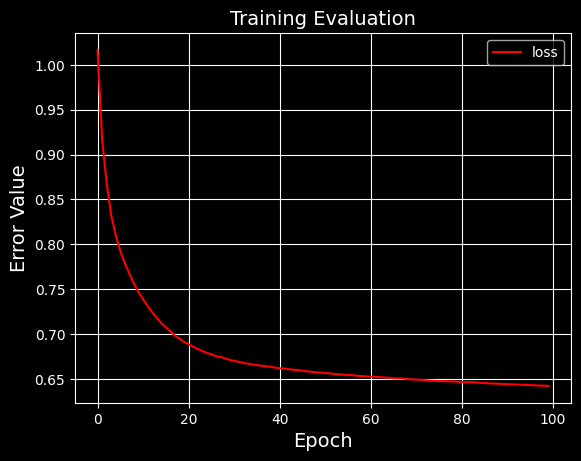

In [144]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [152]:
model = NeuralNetwork(7500,3)
state = torch.load("./torch_models/model_0.pth")
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [153]:
predictions_after = model.forward(torch.Tensor(X_val_vec))
#predictions_after = torch.argmax(predictions_after)
#predictions_after

In [151]:
def topk_encoding(nd_array):
    """
    Function to flatten the predicted category
    """
    
    predictions = nd_array
    
    #ps = torch.exp(predictions)
    top_p, top_class  = predictions.topk(1, dim=1)
    

    return top_class

In [154]:
predictions_after = topk_encoding(predictions_after)
predictions_after

tensor([[1],
        [2],
        [2],
        ...,
        [2],
        [1],
        [2]])

In [160]:
predictions_after = predictions_after.squeeze()
predictions_after.shape

torch.Size([7948])

In [155]:
y_val_vec

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [157]:
tops = torch.argmax(y_val_vec, dim=1)
tops

tensor([1, 2, 2,  ..., 1, 1, 2])

In [158]:
tops.shape

torch.Size([7948])

In [161]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(tops, predictions_after)
accuracy

0.6075742325113236

In [162]:
from sklearn.metrics import classification_report

print(classification_report(tops, predictions_after))

              precision    recall  f1-score   support

           0       0.52      0.41      0.46      1282
           1       0.61      0.63      0.62      3526
           2       0.63      0.66      0.65      3140

    accuracy                           0.61      7948
   macro avg       0.59      0.57      0.57      7948
weighted avg       0.60      0.61      0.60      7948



In [163]:
model = NeuralNetwork(7500,3)
state = torch.load("./torch_models/model_0.pth")
model.load_state_dict(state['state_dict'])

<All keys matched successfully>